In [1]:
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle as pk
from transformers import CLIPProcessor, CLIPModel
from sklearn.neighbors import NearestNeighbors
import torch
import os
from PIL import Image
import json
import gc

#import PCA model
pca_reload = pk.load(open("pca.pkl",'rb'))

# import the kmeans model
kmeans_reload = pk.load(open("kmeans.pkl", 'rb'))

root_dir = '../yars_data'

# load in photots data
photos_data = {}
with open(os.path.join(root_dir, 'photos.json'), 'r') as file:
        for line in file:
            line = line.rstrip()
            try:
                photo_record = json.loads(line)
                photos_data[photo_record['photo_id']] = photo_record
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e} at line: {line}")

/ext3/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/ext3/miniconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Please enter the file path:  test_img2.jpg


The file exists.


[nltk_data] Downloading package stopwords to /home/qz2190/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


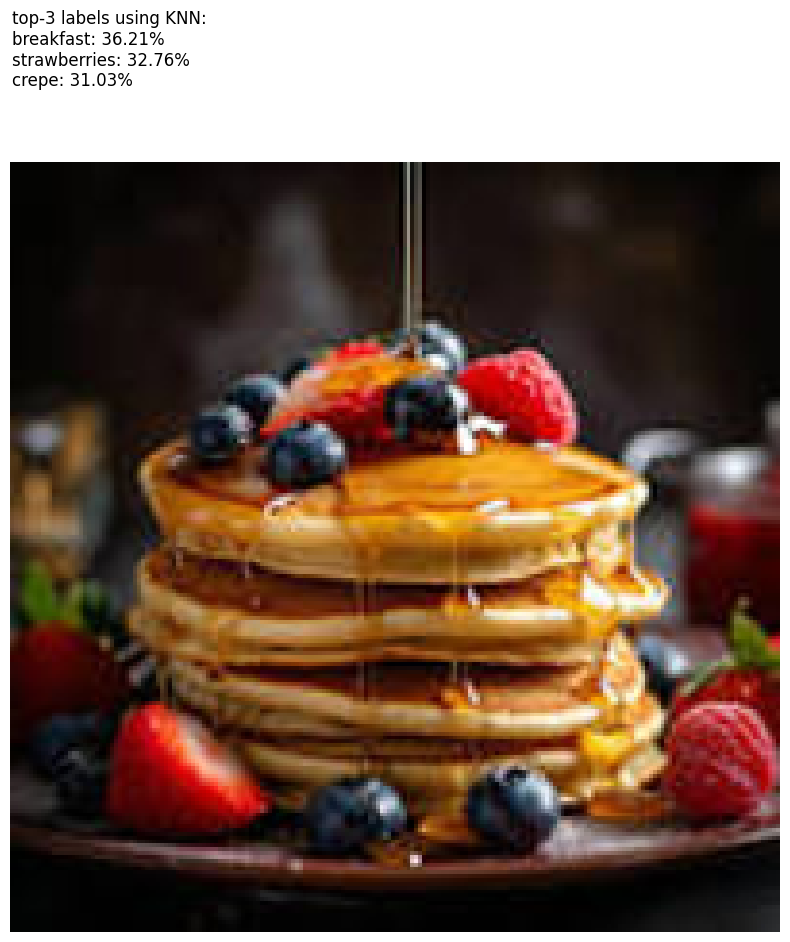

In [6]:
# interactive inputs

while True:
    file_path = input("Please enter the file path: ")
    # Check if the file exists
    if os.path.exists(file_path):
        print("The file exists.")
        break
        # You can add more functionality here, like opening the file.
    else:
        print("No file found at the provided path. Try again or interrupt with Ctrl+C")

images = Image.open(file_path)
inputs = processor(images=images, return_tensors="pt", padding=True).to(device) 
image_features = model.get_image_features(**inputs).detach().cpu().clone()
gc.collect()
torch.cuda.empty_cache()

transformed_embedding = pca_reload.transform(image_features.numpy())
new_label = kmeans_reload.predict(transformed_embedding)

# find k nearest neighbors
k = 150
nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
cluster_embeddings = torch.load(f"{new_label[0]}/embeddings.pt")
with open(f"{new_label[0]}/images.txt", 'r') as file:
    cluster_images = file.readlines()

nbrs.fit(cluster_embeddings)
distances, indices = nbrs.kneighbors(transformed_embedding)
    
neighbor_captions = []
    
for idx in indices[0]:
    image_id = cluster_images[idx].split('/')[-1][:-5]
    neighbor_captions.append(photos_data[image_id]["caption"])

from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def tokenize_and_count(captions):
    # Regular expression to find words
    word_pattern = re.compile(r'\b\w+\b')
    text = ' '.join(captions).lower()
    words = word_pattern.findall(text)
    frequency = Counter(words)
    return frequency

k = 3 # top-k labels
im = Image.open(file_path)
freq = tokenize_and_count(neighbor_captions)
filtered_counts = {word: count for word, count in freq.items() if word not in stop_words}
top_k_labels = sorted(filtered_counts.items(), key=lambda x: x[1], reverse=True)[:k]
total_count = sum(count for _, count in top_k_labels)
top_k_confidence = [(item, (count / total_count) * 100) for item, count in top_k_labels]

plt.figure(figsize=(8, 15)) 
plt.imshow(im.resize((200, 200)))
k_labels = f'top-{k} labels using KNN: \n{"\n".join([f'{label}: {percentage:.2f}%' for label, percentage in top_k_confidence])}'
plt.axis('off')
plt.text(0, -40, k_labels, fontsize=12, va='top')  # Adjust text position and font size as needed

# Show the plot
plt.tight_layout()
plt.show()